<a href="https://colab.research.google.com/github/tuphr2234/ChaosPredition/blob/main/ThreeBodySimulation_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build Simulation

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
import os
from pathlib import Path  


G=1


class Body:
  
  prevPosition=np.array([0,0])
  position=np.array([0,0])
  velocity=np.array([0,0])
  force=np.array([0,0])
  acceleration=np.array([0,0])
  mass=0

  def __init__(self,position,velocity,mass,name):
    self.position=np.array(position)
    self.velocity=np.array(velocity)
    #self.acceleration=np.array(acceleration)
    self.mass=mass
    self.prevPosition=np.array(position)
    self.name = name


  def setPosition(self,t):
    self.prevPosition = self.position
    self.position=self.position+self.velocity*t+(self.acceleration/2)* t**2
  
    


  def setVelocity(self,t):
    self.velocity=self.velocity+self.acceleration*t
  

  def getForce(self,body):
    softening = 0.00001
    Distance = body.prevPosition - self.position
    Rsquare = Distance[0]**2 + Distance[1]**2 + softening
    F = G* self.mass*body.mass / Rsquare  
    normalizeDis = Distance / math.sqrt(Rsquare)
    F = F*normalizeDis
    
    #print(f"body {self.name} force is {F} ")
    
    return F

  def setAcceleration(self,bodies):
    F=np.array([0,0])
    for body in bodies:
      F=F+self.getForce(body)
    self.acceleration = F/self.mass
   # print(f" {self.name} acceleration is {self.acceleration}")

In [2]:
def simulateOnTimeStep(bodies,t,steps,interval_in_data): # bodies: list of bodies. t: timestep . steps: number of steps. interval_in_data : frequency of rows taken to dataset: if equals 1 than it is every step
  dataset = []
  time = []

  for i in range(steps):
      list1=[]
      for body in bodies:
        list1.append(body.position)
      if i % interval_in_data ==0:
        dataset += list1
        time.append(i * t)
      
      for i,body in enumerate(bodies):
        body.setAcceleration([b for b in bodies if b is not body])
        body.setVelocity(t)
        body.setPosition(t)
       
        
      for body in bodies:
        body.prevPosition = body.position
       # plt.scatter(body.position[0],body.position[1])
      #plt.show()  


  return np.array(dataset).reshape(steps//interval_in_data,len(bodies),2),time



In [3]:
def numpyToPandas(simulation,numOfBodies):
  columns = []

  for i in range(numOfBodies):
    columns.append(f'Body{i+1} x')
    columns.append(f'Body{i+1} y')
  simulation_reshaped = simulation.reshape(len(simulation), numOfBodies*2 )

  df = pd.DataFrame(simulation_reshaped, columns = columns)

  return df


Add Filters

In [4]:
#def addNoise(simulation):
#def removeBody(simulation)

Save Simulation

Prepare Dataset 

In [5]:
def prepareData(simulation,window_size_X):
  X = []
  y = []
  for i in range(len(simulation)-window_size_X):
    row = [bodies for bodies in simulation[i:i+window_size_X]]  ### adding time is an option
    X.append(row)
    label = simulation[i+window_size_X]
    y.append(label)
  return np.array(X) , np.array(y)  

In [6]:
def prepareData2(simulation,window_size_X,window_size_y):
  X = []
  y = []
  for i in range(len(simulation)-window_size_X):
    row = simulation[i:i+window_size_X]  ### adding time is an option
    X.append(row)
    label =  simulation[i+window_size_X:i+window_size_X + window_size_y]#######################################
    y.append(label)

  return np.array(X) , np.array(y)


In [7]:
def splitToTrainValidTest(dataset,testPercentage):
  trainLen = round((len(dataset)*(1-testPercentage-0.05)))
  valLen = round((len(dataset)*0.05))
  train_set = dataset[:trainLen]
  val_set = dataset[trainLen:trainLen+valLen]
  test_set = dataset[trainLen+valLen:]
  return train_set,val_set,test_set

Preprocessing/Postprocessing

Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
def buildModelLSTM(window_size_X,numberOfBodies):
  model = Sequential()
  model.add(InputLayer((window_size_X,numberOfBodies*2)))#model.add(InputLayer((window_size_X,numberOfBodies*2)))
  model.add(Conv1D(64, kernel_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(32, kernel_size=2))
  #model.add(TimeDistributed(conv_1d))
  model.add(Flatten())
  #model.add(LSTM(32))
  model.add(Dropout(0.2))
  model.add(Dense(16, 'relu'))
  model.add(Dense(numberOfBodies*2, 'linear'))
  model.summary()
  return model



def buildModelLSTM2(window_size_X,window_size_y,numberOfBodies):
  model = Sequential()
  model.add(InputLayer((window_size_X,numberOfBodies*2)))#model.add(InputLayer((window_size_X,numberOfBodies*2)))
  model.add(Conv1D(64, kernel_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(32, kernel_size=2))
  #model.add(TimeDistributed(conv_1d))
  model.add(Flatten())
  #model.add(LSTM(32))
  model.add(Dropout(0.2))
  model.add(Dense(16, 'relu'))
  model.add(Dense(numberOfBodies*2*window_size_y, 'linear'))
  model.add(tf.keras.layers.Reshape((window_size_y, numberOfBodies*2)))
  model.summary()
  return model

Training Model

In [9]:
#position,velocity,acceleration,mass
#%%timeit
bodies=[]
bodies.append(Body([-1, 0],[0.4662036850, 0.4323657300],1,"body1"))
bodies.append(Body([0,0],[-0.93240737, -0.86473146],1.1,"body2"))
bodies.append(Body([1, 0],[0.4662036850, 0.4323657300],1,"body3"))
bodies.append(Body([2, -0.24308753],[-0.4662036850, 0.4323657300],1,"body4"))

numOfBodies=len(bodies)

#bodies.append(Body([1, 0],[0, 0],1,"body1"))
#bodies.append(Body([0,1],[0, 0],1.1,"body2"))
#bodies.append(Body([0, 0],[0, 0],1,"body3"))



simulation1,timesteps = simulateOnTimeStep(bodies,0.01,1000000,100)
simulation1=simulation1.reshape(len(simulation1), numOfBodies*2 )


In [10]:
## save simulation as csv
def saveSimulation(simulation,numOfBodies,simulation_name):
  df = numpyToPandas(simulation,numOfBodies) 
  df.to_csv(f'/content/{simulation_name}.csv')

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
from scipy.fft import fft, ifft

#batch = 6


train, val, test = splitToTrainValidTest(simulation1,0.2)

windowSizeX=10
windowSizeY = 10
scaled = True 

model =  buildModelLSTM(windowSizeX,numOfBodies)
#model =  buildModelLSTM2(windowSizeX,windowSizeY,numOfBodies)
cp1 = ModelCheckpoint('model/', save_best_only=True)
#lr_schedule = ExponentialDecay(
  #  initial_learning_rate=1e-2,
 #   decay_steps=10000,
  #  decay_rate=0.9)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])


if scaled:
  scaler = StandardScaler()
  scaler.fit(simulation1[:len(train)+len(val)])
  #valScaler.fit(train)  ### train / val as input ? 

  train = scaler.transform(train)
  val = scaler.transform(val)
  #train = hilbert(train)
  #val = hilbert(val)
#y_train = scaler.fit(train)

#sc = MinMaxScaler(feature_range = (0, 1))

#train_scaled = sc.fit_transform(train)
#val_scaled = sc.fit_transform(val) ## ???
#test_scaled = sc.fit_transform(test) ## ???

#generator = TimeseriesGenerator(train_scaled,train_scaled,length = len(test),batch_size=batch)
print(f"fsdsdfsf {model.output_shape}")

#X_train, y_train = prepareData2(train_scaled,windowSizeX,windowSizeY)
#X_val, y_val = prepareData2(val_scaled,windowSizeX,windowSizeY)
#X_test, y_test = prepareData2(test_scaled,windowSizeX,windowSizeY)

#X_train, y_train = prepareData(train_scaled,windowSizeX)
#X_val, y_val = prepareData(val_scaled,windowSizeX)
#X_test, y_test = prepareData(test_scaled,windowSizeX)

X_train, y_train = prepareData(train,windowSizeX)
X_val, y_val = prepareData(val,windowSizeX)
X_test, y_test = prepareData(test,windowSizeX)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 64)             1088      
                                                                 
 dropout (Dropout)           (None, 9, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 32)             4128      
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 16)                4112      
                                                                 
 dense_1 (Dense)             (None, 8)                 1

In [12]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, callbacks=[cp1])

Epoch 1/300
235/235 [==============================] - 13s 9ms/step - loss: 0.3961 - root_mean_squared_error: 0.6294 - val_loss: 0.2543 - val_root_mean_squared_error: 0.5043
Epoch 2/300
235/235 [==============================] - 2s 7ms/step - loss: 0.1354 - root_mean_squared_error: 0.3680 - val_loss: 0.1150 - val_root_mean_squared_error: 0.3391
Epoch 3/300
235/235 [==============================] - 2s 7ms/step - loss: 0.0847 - root_mean_squared_error: 0.2910 - val_loss: 0.0533 - val_root_mean_squared_error: 0.2309
Epoch 4/300
235/235 [==============================] - 2s 7ms/step - loss: 0.0558 - root_mean_squared_error: 0.2362 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1555
Epoch 5/300
235/235 [==============================] - 2s 7ms/step - loss: 0.0403 - root_mean_squared_error: 0.2007 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1401
Epoch 6/300
235/235 [==============================] - 2s 8ms/step - loss: 0.0302 - root_mean_squared_error: 0.1736 - val_loss: 0.0099

In [13]:
#history = model.fit_generator(generator,epochs=100,verbose=1)

Predictions

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
predictions = model.predict(X_test)          ###############  LOCAL RMSE  (prediction per window)
#predictions = sc.inverse_transform(predictions)
print(math.sqrt(mean_squared_error(test[windowSizeX:],predictions)))


114706.33018929906


In [16]:
def slidingWindowActualPredictions(model,windowArr,windowSize,NumOfBodies,predictionsRequestedNumber):
  

  actualPredictionArr =[]
  for i in range(predictionsRequestedNumber):

    prediction = model.predict(windowArr[-1:]) ### predict from last window
    actualPredictionArr.append(prediction)
    temp = np.zeros([windowSize,numOfBodies*2])
    temp = temp + windowArr[-1]
    temp =temp[1:]
    newWindow = np.append(temp.reshape(windowSize-1,numOfBodies*2),prediction)
    newWindow = newWindow.reshape(windowSize,numOfBodies*2)
    lengthX = len(windowArr)
    windowArr = np.append(windowArr,newWindow) ### add new window that the last vector is the prediction 
    windowArr = windowArr.reshape(lengthX+1,windowSize,numOfBodies*2)

  return actualPredictionArr

In [17]:
import math

listOfPredictions = slidingWindowActualPredictions(model,X_train,windowSizeX,numOfBodies,len(val)+len(test))
listOfPredictions =np.array(listOfPredictions)
listOfPredictions = listOfPredictions.squeeze()
if scaled:
  listOfPredictions = scaler.inverse_transform(listOfPredictions)


In [18]:
simulation1[len(X_train)+windowSizeX:].shape

(2500, 8)

In [19]:
print(math.sqrt(mean_squared_error(simulation1[len(X_train)+windowSizeX:],listOfPredictions))) ##### ACTUAL RMSE #####


2743.414865382368


In [20]:
#listOfPredictions = sc.inverse_transform(listOfPredictions)
#print((np.linalg.norm(simulation1[len(X_train)+windowSize:]-listOfPredictions)))
#arr=[]
#for i in range(len(listOfPredictions)):
 # arr.append(np.linalg.norm(simulation1[len(X_train)+windowSize+i]-listOfPredictions[i]) )


#print(arr)
#print(np.argmin(arr))


In [21]:
print((simulation1[len(X_train)+windowSizeX]))

print((train[-1:]))
#y_train =sc.inverse_transform(y_train)
#print((y_train[-1:]))
print(listOfPredictions[0])
print((scaler.inverse_transform(model.predict(X_train[-1:]))))

[  15584.37794359   19041.36076594   -3754.62596973  -16535.1965764
   68524.71544302 -241906.9144267   -84172.83798488  243648.22118726]
[[ 1.51532755  1.51532729 -1.51532615 -1.51532724  1.51532813 -1.51532813
  -1.51532811  1.51532812]]
[  15577.573    19040.014    -3753.4675  -16533.947    68544.11
 -241855.64    -84186.01    243549.44  ]
[[  15577.573    19040.014    -3753.4675  -16533.947    68544.11
  -241855.64    -84186.01    243549.44  ]]


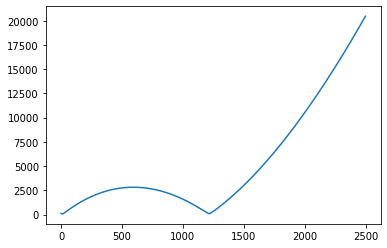

In [22]:
import matplotlib.pyplot as plt
disArr = []
for i in range(len(val)+len(test)):
  disArr.append(np.linalg.norm(simulation1[len(X_train)+windowSizeX+i]-listOfPredictions[i]))

plt.plot(disArr[:])  

In [23]:
len(disArr)


2500

In [24]:
simulation1.shape

(10000, 8)

In [25]:
bodies=[]
bodies.append(Body([-1, 0],[0.4662036860, 0.4323657300],1,"body1"))
bodies.append(Body([0,0],[-0.93240737, -0.86473146],1.1,"body2"))
bodies.append(Body([1, 0],[0.4662036850, 0.4323657300],1,"body3"))
bodies.append(Body([2, -0.24308753],[-0.4662036850, -0.4323657300],1,"body4"))


simulation2 = simulateOnTimeStep(bodies,0.01,100000,10)

In [26]:
distance = simulation1 - simulation2
curentDis=0
disArr = []
for i in range(100000):
  for j in range(4):
    curentDis = curentDis + math.sqrt(distance[i][j][0]**2 + distance[i][j][1]**2) 
  disArr.append(curentDis)
  curentDis=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [ ]:
time=[]
for i in range(100000):
  time.append(i*0.01)
plt.plot(time[0:10000],disArr[0:10000])
plt.show()

In [ ]:
disArr = np.array(disArr)
shiftdisArr=disArr[1:]
shiftdisArr=np.append(shiftdisArr,[0])
len(shiftdisArr)


In [ ]:
disArrderiv = (shiftdisArr - disArr)/0.01

In [ ]:
time=[]
for i in range(100000):
  time.append(i*0.01)
plt.plot(time[500:40000],disArrderiv[500:40000])
plt.show()

7.79577126e+02, -9.26696926e+01],
        [-5.58506324e+02, -3.53116807e+02],
        [-2.21070801e+02,  4.45786500e+02]],

       [[ 7.79584934e+02, -9.26706237e+01],
        [-5.58511912e+02, -3.53120340e+02],
        [-2.21073022e+02,  4.45790964e+02]],

       [[ 7.79592742e+02, -9.26715547e+01],
        [-5.58517500e+02, -3.53123872e+02],
        [-2.21075242e+02,  4.45795427e+02]]])




array([[[-9.70004360e-01,  2.43087530e-01],
        [ 0.00000000e+00,  1.00000000e-03],
        [ 9.70004360e-01, -2.43087530e-01]],

       [[-9.69536336e-01,  2.43519441e-01],
        [-9.32409492e-04,  1.35266072e-04],
        [ 9.70468746e-01, -2.42654707e-01]],

       [[-9.69067097e-01,  2.43951046e-01],
        [-1.86482529e-03, -7.29463332e-04],
        [ 9.70931923e-01, -2.42221583e-01]],

       ...,

       [[ 2.27972866e-01,  5.47142180e-01],
        [-5.44147288e-02,  9.10547188e-02],
        [-1.73558137e-01, -6.37196899e-01]],

       [[ 2.28379125e-01,  5.46270579e-01],
        [-5.53558817e-02,  9.23559792e-02],
        [-1.73023244e-01, -6.37626558e-01]],

       [[ 2.28783319e-01,  5.45395410e-01],
        [-5.62954630e-02,  9.36583987e-02],
        [-1.72487856e-01, -6.38053809e-01]]])


















test